In [63]:
#

43.48413416642747


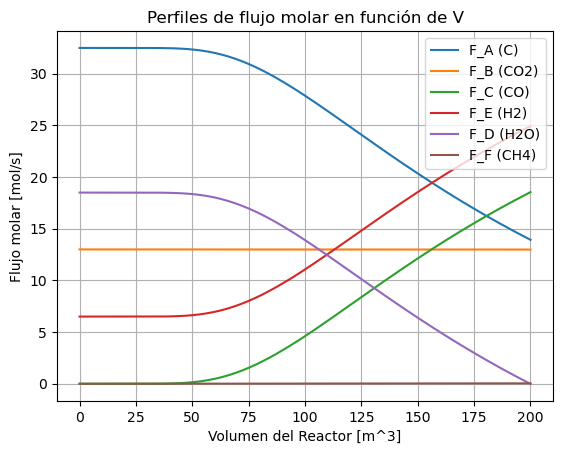

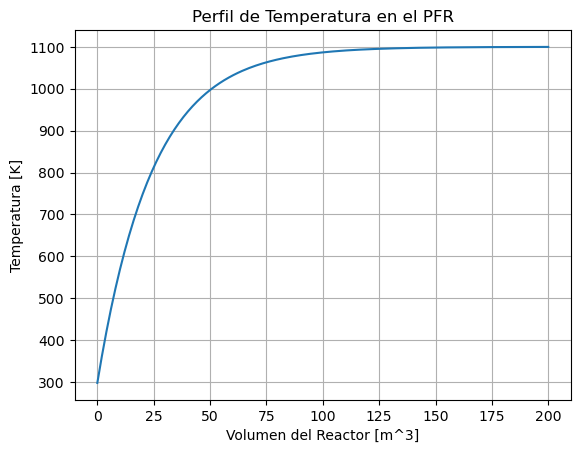

In [64]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# ------------------------------------------------------------
# 1. DATOS Y PARÁMETROS GLOBALES
# ------------------------------------------------------------

R = 8.314         # Constante de gases ideales [J/(mol·K)]
P = 1.01325       # Presión total [bar] (1 atm ~ 1.01325 bar)

# Diccionario con las 3 reacciones simultáneas.
# Formato:
#  "nombre_reaccion": {
#       "A": (factor preexponencial),
#       "n": (orden respecto a la presión parcial),
#       "Ea": (energía de activación en J/mol),
#       "P_init": (fracción molar inicial del reactivo asociado)
#  }
# ------------------------------------------------------------
reactions = {
    "Reacción 1: C + CO2 -> 2 CO": {
        "A": 3.1e6,        # s^-1 bar^-0.38 (ejemplo)
        "n": 0.38,
        "Ea": 215e3,       # J/mol
        "P_init": 0.738 / 157.67  # Fracción inicial 'efectiva' de CO2
    },
    "Reacción 2: C + H2O -> CO + H2": {
        "A": 123e6,
        "n": 0.75,
        "Ea": 198e3,
        "P_init": 12.08 / 157.67  # Fracción inicial 'efectiva' de H2O
    },
    "Reacción 3: C + 2H2 -> CH4": {
        "A": 4.189e-3,
        "n": 1.2,
        "Ea": 19210,       # J/mol
        "P_init": 1.2 / 157.67  # Fracción inicial 'efectiva' de H2
    },
}

# Para el balance de energía, solemos necesitar entalpías de formación o
# calores de reacción. Aquí, como ejemplo, se incluyen:
#   - Hf: entalpías de formación estándar (sólo DEMO, ajustar en la práctica)
#   - Cp: capacidades caloríficas (DEMOSTRATIVAS)
#
# Se asume que el orden de especies es:
#   A = C, B = CO2, C = CO, D = H2O, E = H2, F = CH4, I (posible inerte)
#
# Unidades: su contenido original sugiere [kJ/kmol] o [J/mol],
# dependiendo del factor e-6. Ajustar con cuidado.
# ------------------------------------------------------------
Hf = [ 
    0.0,          # C(s)
    -393509e-6,   # CO2
    -110525e-6,   # CO
    -241818e-6,   # H2O
    0.0,          # H2
    -74810e-6,    # CH4
    0.0           # Inerte (si lo hubiera)
]
Cp = [
    8.53,  # C(s)
    37.1,  # CO2
    29.1,  # CO
    33.6,  # H2O
    28.8,  # H2
    35.7,  # CH4
    29.1   # Inerte (si aplica)
]

# Estequiometría (coeficientes) de cada reacción en términos de [A,B,C,D,E,F].
# (I se asume 0 en todas si no participa.)
# ------------------------------------------------------------
# Reacción 1: C + CO2 -> 2 CO
stoich_r1 = [-1, -1, +2,  0,  0,  0]
# Reacción 2: C + H2O -> CO + H2
stoich_r2 = [-1,  0, +1, -1, +1,  0]
# Reacción 3: C + 2H2 -> CH4
stoich_r3 = [-1,  0,  0,  0, -2, +1]

# Cálculo de los calores de reacción a Tref, sumando entalpías de formación
# ΔHr (J/mol) = sum_i( ν_i * Hf[i]*(factorConversion?) ).
# Ajusta si tus Hf están en kJ/mol y quieres J/mol => multiplicar por 1e3, etc.
# Aquí, se asume que Hf ya está en J/mol aproximadamente (revisa con cuidado).
# ------------------------------------------------------------
def enthalpy_of_reaction(stoich, Hf_array):
    return sum(nu_i * Hf_array[i] for i, nu_i in enumerate(stoich))

DeltaH1 = enthalpy_of_reaction(stoich_r1, Hf)  # J/mol
DeltaH2 = enthalpy_of_reaction(stoich_r2, Hf)  # J/mol
DeltaH3 = enthalpy_of_reaction(stoich_r3, Hf)  # J/mol

# Parámetros del reactor y del modelo energético
# ------------------------------------------------------------
U = 1          # Coef. global de transferencia de calor [J/(s·m^2·K)] (ejemplo)
a = 40         # Área por volumen [m^2/m^3]
T_ext = 1100.0    # Temperatura externa de la camisa [K]
Cp_medio = 15   # Valor promedio [J/(mol·K)] (simple DEMO)
V_total = 200     # Volumen total del PFR [m^3]
Ftot0 = 6.5*10 # Caudal total (mol/s) 

# Flujos molares iniciales de cada especie: [FA0, FB0, FC0, FD0, FE0, FF0]
# Ajusta según tu mezcla de entrada real.
FA0 = 0.5 * Ftot0
FB0 = 0.2 * Ftot0
FC0 = 0.0
FD0 = 0.2 * Ftot0
FE0 = 0.1 * Ftot0
FF0 = 0.0
# (Si hay un inerte, FI0, se puede añadir.)

T0 = 298.15   # Temperatura inicial de la corriente [K]

# ------------------------------------------------------------
# 2. FUNCIÓN CINÉTICA: total_reaction_rate
# ------------------------------------------------------------
def total_reaction_rate(reactions, T, X):
    """
    Calcula la velocidad de reacción para cada reacción
    en función de la temperatura T y la conversión X.
    """
    rates = {name: np.zeros_like(X) for name in reactions.keys()}

    for name, params in reactions.items():
        # Asegurar que P_current no sea negativo
        P_current = P * (params["P_init"] * max(1 - X, 1e-6)) * 0.08314 * T
        
        # Asegurar que k no sea cero ni NaN
        k = params["A"] * np.exp(-params["Ea"] / (R * max(T, 1e-6)))

        # Asegurar que P_current no sea negativo antes de elevarlo a una potencia
        if np.any(P_current <= 0):
            print(f"⚠️ Advertencia: P_current negativo en {name}, ajustando a 1e-6")
            P_current = np.maximum(P_current, 1e-6)

        # Calcular velocidad de reacción
        rates[name] = k * (P_current ** params["n"])

    return rates

# ------------------------------------------------------------
# 3. DEFINICIÓN DEL SISTEMA DE EDOs PARA EL PFR
# ------------------------------------------------------------
# Asumiremos un "modelo simplificado" donde:
#  - y[0] = F_A  (flujo de C)
#  - y[1] = F_B  (flujo de CO2)
#  - y[2] = F_C  (flujo de CO)
#  - y[3] = F_D  (flujo de H2O)
#  - y[4] = F_E  (flujo de H2)
#  - y[5] = F_F  (flujo de CH4)
#  - y[6] = T    (temperatura)
#
# dFA/dV = stoich_r1[A]*r1 + stoich_r2[A]*r2 + stoich_r3[A]*r3, etc.
# Donde r1, r2, r3 se calculan con 'total_reaction_rate'.
# Para simplificar, calculamos X en función de FA (si FA0 es el reactivo base).
#    X = (FA0 - FA) / FA0
# ------------------------------------------------------------
def pfr_equations(V, y):
    # Extraer flujos y T desde y
    FA, FB, FC, FD, FE, FF, T = y

    # Calcular conversión 'X' del reactivo A (C):
    X = (FA0 - FA) / FA0  # supondremos A como "limitante"

    # Calcular velocidades de reacción (r1, r2, r3) 
    # a partir de la función total_reaction_rate
    # OJO: la función asume que 'T' y 'X' pueden ser arrays,
    #      aquí son escalares => convertimos a np.array([X])
    #      y luego tomamos la posición [0].
    rates_dict = total_reaction_rate(reactions, T, np.array([X]))
    r1 = rates_dict["Reacción 1: C + CO2 -> 2 CO"][0]
    r2 = rates_dict["Reacción 2: C + H2O -> CO + H2"][0]
    r3 = rates_dict["Reacción 3: C + 2H2 -> CH4"][0]

    # (r1, r2, r3) tienen unidades "mol/(s·m^3)" en la mayoría de configuraciones 
    # si A se definió en s^-1 y la presión parcial está en bar^n, etc.
    # Ajustar si tus unidades difieren.

    # BALANCE DE MATERIA para cada especie:
    dFA_dV = stoich_r1[0]*r1 + stoich_r2[0]*r2 + stoich_r3[0]*r3  # A (C)
    dFB_dV = stoich_r1[1]*r1 + stoich_r2[1]*r2 + stoich_r3[1]*r3  # B (CO2)
    dFC_dV = stoich_r1[2]*r1 + stoich_r2[2]*r2 + stoich_r3[2]*r3  # C (CO)
    dFD_dV = stoich_r1[3]*r1 + stoich_r2[3]*r2 + stoich_r3[3]*r3  # D (H2O)
    dFE_dV = stoich_r1[4]*r1 + stoich_r2[4]*r2 + stoich_r3[4]*r3  # E (H2)
    dFF_dV = stoich_r1[5]*r1 + stoich_r2[5]*r2 + stoich_r3[5]*r3  # F (CH4)

    # BALANCE DE ENERGÍA
    # Calculamos la suma de calor de reacción:
    #   sum_reac = (ΔH1 * r1 + ΔH2 * r2 + ΔH3 * r3)
    # (Cuidado con signos: si ΔH < 0 => exotérmica => genera calor.)
    sum_reac = (DeltaH1 * r1) + (DeltaH2 * r2) + (DeltaH3 * r3)

    # Flujo total (mol/s) aproximado:
    F_total = (FA + FB + FC + FD + FE + FF)  # si no hay inertes

    # Supongamos un Cp_medio ~ cte. Ajustar en la práctica sumando Cp_i * Fi / F_total
    # o algo más sofisticado.
    # Término de intercambio de calor con la camisa: U*a*(T - T_ext).
    # El balance de energía (por unidad de volumen) -> dT/dV:
    #    dT/dV = [- sum_reac - U*a*(T - T_ext)] / [F_total * Cp_medio]
    dT_dV = ( - sum_reac - U * a * (T - T_ext) ) / ( F_total * Cp_medio )

    return [dFA_dV, dFB_dV, dFC_dV, dFD_dV, dFE_dV, dFF_dV, dT_dV]

# ------------------------------------------------------------
# 4. RESOLVER EL SISTEMA DE ODEs
# ------------------------------------------------------------
# y0 = condición inicial [FA0, FB0, FC0, FD0, FE0, FF0, T0]
y0 = [FA0, FB0, FC0, FD0, FE0, FF0, T0]

# Integramos desde V = 0 hasta V = V_total
sol = solve_ivp(
    fun=pfr_equations,
    t_span=(0, V_total),
    y0=y0,
    dense_output=True
)

# Puntos de evaluación para graficar
n_points = 200
V_eval = np.linspace(0, V_total, n_points)
sol_eval = sol.sol(V_eval)   # shape => [7, len(V_eval)]

FA_profile = sol_eval[0]
FB_profile = sol_eval[1]
FC_profile = sol_eval[2]
FD_profile = sol_eval[3]
FE_profile = sol_eval[4]
FF_profile = sol_eval[5]
T_profile  = sol_eval[6]

# Cálculo de conversión final de A
FA_final = FA_profile[-1]
X_final = (FA0 - FA_final) / FA0

#print(f"Conversión final de A (C) = {X_final:.3f}")
#print(f"Temperatura de salida = {T_profile[-1]:.2f} K")
print(FC_profile[-1] + FE_profile[-1])

# ------------------------------------------------------------
# 5. GRÁFICAS
# ------------------------------------------------------------
plt.figure()
plt.plot(V_eval, FA_profile, label='F_A (C)')
plt.plot(V_eval, FB_profile, label='F_B (CO2)')
plt.plot(V_eval, FC_profile, label='F_C (CO)')
plt.plot(V_eval, FE_profile, label='F_E (H2)')
plt.plot(V_eval, FD_profile+5.5, label='F_D (H2O)')
plt.plot(V_eval, FF_profile, label='F_F (CH4)')
plt.xlabel('Volumen del Reactor [m^3]')
plt.ylabel('Flujo molar [mol/s]')
plt.title('Perfiles de flujo molar en función de V')
plt.legend()
plt.grid(True)
plt.show()

plt.figure()
plt.plot(V_eval, T_profile, label='Temperatura')
plt.xlabel('Volumen del Reactor [m^3]')
plt.ylabel('Temperatura [K]')
plt.title('Perfil de Temperatura en el PFR')
plt.grid(True)
plt.show()
